In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils import roc_results, gdf_pca, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [3]:
data_length = 24000
stocks = stocks_numbers.chosen_stocks
should_save_fig = False

In [14]:
df_scores = pd.read_csv('../gdf_pca/res_log_que.csv')
df_scores = df_scores[df_scores['stock'].isin(stocks)]

,test_matthews,matthews,test_roc_auc,roc_auc
count,15.000000,15.000000,15.000000,15.000000
mean,0.114487,0.118594,0.566008,0.567710
std,0.024214,0.026024,0.019496,0.019417
min,0.047951,0.057241,0.524117,0.528676
25%,0.106400,0.109996,0.557095,0.558588
50%,0.124435,0.122816,0.570149,0.569671
75%,0.132662,0.138463,0.573070,0.578162
max,0.138680,0.146427,0.600747,0.602119


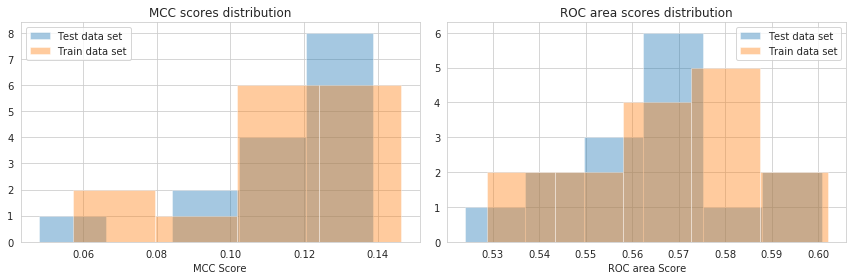

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_scores['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_scores['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_scores['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_scores['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
#plt.savefig('results_log_que_score_dist.png')

df_scores[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

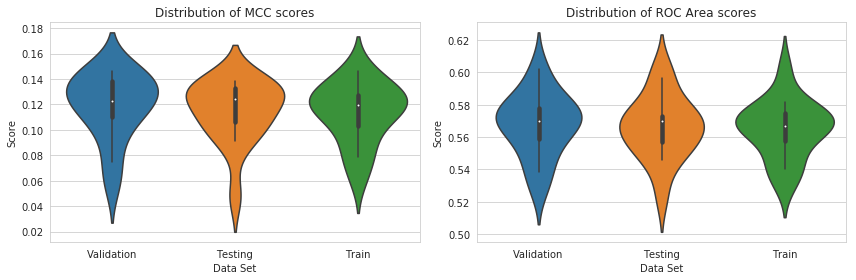

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc']

df = df_scores[columns].copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc', 'test_roc_auc', 'train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_scores[columns].copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews', 'test_matthews', 'train_matthews'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
plt.savefig('violin_distribution_scores_log_que.png')

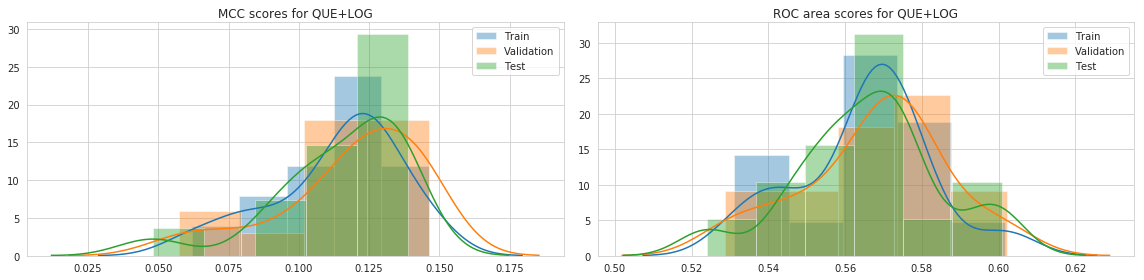

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

sns.distplot(df_scores[['train_matthews']], label='Train', ax=ax1)
sns.distplot(df_scores[['matthews']], label='Validation', ax=ax1)
sns.distplot(df_scores[['test_matthews']], label='Test', ax=ax1)
ax1.legend()
ax1.set_title('MCC scores for QUE+LOG')

sns.distplot(df_scores[['train_roc_auc']], label='Train', ax=ax2)
sns.distplot(df_scores[['roc_auc']], label='Validation', ax=ax2)
sns.distplot(df_scores[['test_roc_auc']], label='Test', ax=ax2)
ax2.legend()
ax2.set_title('ROC area scores for QUE+LOG')
plt.tight_layout()
if should_save_fig:
    plt.savefig('results_que_log.png')

In [17]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
        'train_roc_auc', 'roc_auc', 'test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews &  train\_roc\_auc &    roc\_auc &  test\_roc\_auc \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 &      15.000000 &  15.000000 &     15.000000 \\
mean  &        0.113381 &   0.118594 &       0.114487 &       0.564999 &   0.567710 &      0.566008 \\
std   &        0.023562 &   0.026024 &       0.024214 &       0.017799 &   0.019417 &      0.019496 \\
min   &        0.062033 &   0.057241 &       0.047951 &       0.531175 &   0.528676 &      0.524117 \\
25\%   &        0.102948 &   0.109996 &       0.106400 &       0.557315 &   0.558588 &      0.557095 \\
50\%   &        0.119528 &   0.122816 &       0.124435 &       0.567023 &   0.569671 &      0.570149 \\
75\%   &        0.127260 &   0.138463 &       0.132662 &       0.574729 &   0.578162 &      0.573070 \\
max   &        0.146122 &   0.146427 &       0.138680 &       0.601755 &   0.602119 &      0.600747 \\
\bottomrule
\end{tabula

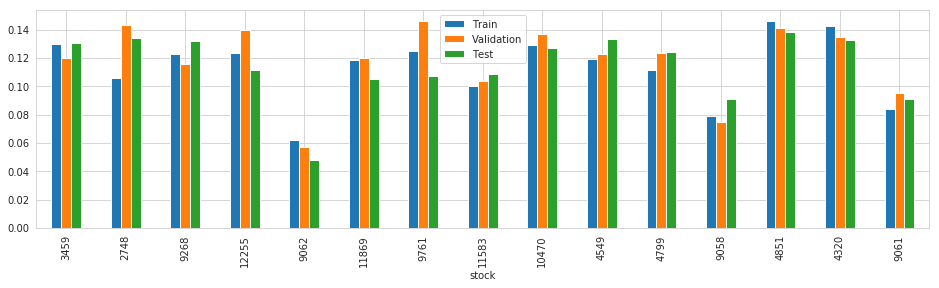

In [24]:
df_scores.index = df_scores['stock']
df_scores[['train_matthews', 'matthews', 'test_matthews']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test'])